enter filename .txt read.txt
enter savefile .txt to save information info.txt
enter savefile .pdf to save plot plots.pdf
enter date collected 25th Oct


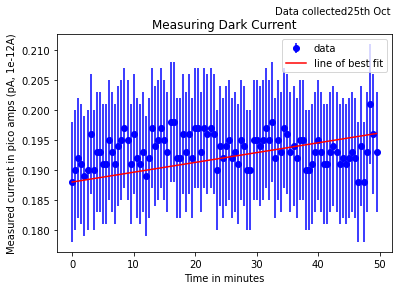

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def readfile(filename):
    """
    Reads file name and generate x and y data for plotting
    Parameters
    ----------
    filename : The name of the file to be plotted.

    Returns
    -------
    x : x data for plot.
    y : y data for plot.

    """
    a = np.loadtxt(filename)
    x = a[:,0]/2
    y = a[:,1]/1e-12
    mean = np.mean(y)
    std = np.std(y)
    return x ,y, mean, std 

def evaluate_model(m,c,x):
    """
    Creates line y = mx + c
    
    Parameters:
    ------------
    m: slope 
    x: x data points 
    c: line constant
    
    Returns:
    --------
    mx + c for all points x
    """
    return m*x+c

def evaluate_chi2(zipped_data,m,c):
    """
    Evaluates chi2
    
    Parameters:
    ------------
    m: slope
    c: line constant
    
    Returns:
    --------
    chi2_value: value of chi2 found
    """
    chi2_value = 0
    for x,y,err in zipped_data:
        delta = y-evaluate_model(m,c,x)
        chi2_contribution = (delta*delta)/(err*err)
        chi2_value += chi2_contribution
    return chi2_value

def loop(chi2_tolerance,data_x,data_y,m0,c0,chi2_0,zipped_data): 
    #let's set a sensible first step for m and c.
    ymax = max(data_y)
    ymin = min(data_y)
    x_ymax = data_x[data_y.index(ymax)]
    x_ymin = data_x[data_y.index(ymin)]
    mext = (ymax-ymin)/(x_ymax-x_ymin)
    cext = ymax - mext*x_ymax  
    deltam = (mext-m0)/2
    deltac = (cext-c0)/2
    ini_deltam = deltam
    ini_deltac = deltac
    #get ready to loop!
    chi2_current = chi2_0
    m_current = m0 + deltam
    c_current = c0
    chi2_new = evaluate_chi2(zipped_data,m_current,c_current)
    chi2_diff = chi2_new - chi2_current
    chi2_current = chi2_new

    #loop!
    keepGoing_m = True
    keepGoing_c = True
    loopRunning = True
    chi2_calls = 2

    while(loopRunning):
        chi2_start = chi2_current

        while (keepGoing_m):
            #vary m
            if chi2_diff > 0:
                deltam = -0.5*deltam
            m_current = m_current+deltam
            chi2_calls += 1
            chi2_new = evaluate_chi2(zipped_data,m_current,c_current)
            chi2_diff = chi2_new - chi2_current
            chi2_current = chi2_new
            keepGoing_m = abs(chi2_diff) > chi2_tolerance
        if chi2_diff < 0:
            m_current = m_current+deltam

        while (keepGoing_c):
            #vary c
            if chi2_diff > 0:
                deltac = -0.5*deltac
            c_current = c_current+deltac
            chi2_calls += 1
            chi2_new = evaluate_chi2(zipped_data,m_current,c_current)
            chi2_diff = chi2_new - chi2_current
            chi2_current = chi2_new
            keepGoing_c = abs(chi2_diff) > chi2_tolerance
        if chi2_diff < 0:
            c_current = c_current+deltac

        chi2_diff_loop = chi2_current - chi2_start
        keepGoing_m = True
        keepGoing_c = True
        loopRunning = abs(chi2_diff_loop) > chi2_tolerance
    return ini_deltam, ini_deltac, deltam, deltac, m_current, c_current, chi2_current

def m_uncertainty(deltam,delta_chi2_1sigma,m_best, c_best, zipped_data):
    m_unc = 1.0*deltam
    m_unc_deltachi2 = 0
    while m_unc_deltachi2 < delta_chi2_1sigma:
        m_unc_chi2 = evaluate_chi2(zipped_data, m_best+m_unc,c_best)
        m_unc_deltachi2 = m_unc_chi2-chi2_min
        m_unc+=deltam
    return m_unc

def c_uncertainty(deltam,delta_chi2_1sigma,m_best, c_best, zipped_data):
    c_unc = 1.0*deltac
    c_unc_deltachi2 = 0
    while c_unc_deltachi2 < delta_chi2_1sigma:
        c_unc_chi2 = evaluate_chi2(zipped_data, m_best,c_best+c_unc)
        c_unc_deltachi2 = c_unc_chi2-chi2_min
        c_unc+=deltam
    return c_unc

def textfile(savetext,m0,c0,chi2_0,ini_deltam,ini_deltac,chi2_calls,
             deltam,deltac,m_best,m_unc,c_best,c_unc,chi2_min, mean, std, model_y):
    with open(savetext, 'w') as f:
        f.write('Setting initial values:')
        f.write("\n")
        f.write(str('m: ') + str(m0))
        f.write("\n")
        f.write(str('c: ') + str(c0))
        f.write("\n")
        f.write(str('chi2 for initial values: ') + str(chi2_0))
        f.write("\n")
        f.write(str('First step sizes: ') + str(ini_deltam) + " , " + str(ini_deltac))
        f.write("\n")
        f.write("\n")
        f.write("final values:")
        f.write("\n")
        f.write(str('Number Evaluations for central values: ')+ str(chi2_calls))
        f.write("\n")
        f.write(str('Final Step Sizes: ')+str(deltam)+ ' , '+ str(deltac))
        f.write("\n")
        f.write(str('Best fit m: ')+ str(m_best)+ ' ' + str('+/-')+ ' ' + str(m_unc))
        f.write("\n")
        f.write(str('Best fit c: ')+ str(c_best)+ ' ' + str('+/-')+ ' ' + str(c_unc))
        f.write("\n")
        f.write(str('Minimum chi2: ')+ str(chi2_min))
        f.write("\n")
        f.write(str('mean ') + str(mean) + " , " + str('std ') + str(std))
        f.write("\n")
        f.write(str('model mean ') + str(np.mean(model_y)) + " , " + str('model std ') + str(np.std(model_y)))
    f.close()

def plot(savefile, data_x, data_y, model_y, data_yerr, date):
    plot_x = np.array(data_x)
    plot_y = np.array(data_y)
    plot_modely = np.array(model_y)
    plot_yerr = np.array(data_yerr)
    
    plt.errorbar(plot_x,plot_y,plot_yerr, fmt = 'o', c = 'blue', label = 'data')
    plt.errorbar(x=plot_x,y=plot_modely,c='red', label = 'line of best fit')
    plt.legend()
    plt.title('Measuring Dark Current')
    plt.xlabel('Time in minutes')
    plt.ylabel('Measured current in pico amps (pA, 1e-12A)')
    plt.figtext(0.63,0.95,'Data collected' + str(date))
    plt.savefig(savefile, format = 'pdf')
    plt.show()


#let's setup a tolerance:
chi2_tolerance = 0.001

#define the change in chi2 for 1 sigma
delta_chi2_1sigma = 1.0
filename = input('enter filename .txt ')
data_x, data_y = readfile(filename)[0].tolist(), readfile(filename)[1].tolist()
_,_,mean,std = readfile(filename)
data_yerr = (np.ones(len(data_x))*0.01).tolist()
zipped_data = list(zip(data_x,data_y,data_yerr))

#let's set some sensible(?) first values for m and c:
m0 = (data_y[-1]-data_y[0])/(data_x[-1]-data_x[0])
c0 = data_y[-1] - m0*data_x[-1]  

#now evaluate chi2 
chi2_0 = evaluate_chi2(zipped_data,m0,c0)
chi2_calls = 2
#looping
ini_deltam, ini_deltac, deltam, deltac, m_best, c_best, chi2_min = loop(chi2_tolerance,
                                                                        data_x,data_y,m0,c0,chi2_0,zipped_data)

#get the uncertainty on m and c:
m_unc = m_uncertainty(deltam,delta_chi2_1sigma,m_best, c_best, zipped_data)
c_unc = c_uncertainty(deltam,delta_chi2_1sigma,m_best, c_best, zipped_data)

#plot to check the result is reasonable
model_y = []
for x in data_x:
    model_y.append(evaluate_model(m_best,c_best,x))

#save information to txt file
savetext = input('enter savefile .txt to save information ')
textfile(savetext,m0,c0,chi2_0,ini_deltam,ini_deltac,chi2_calls,
             deltam,deltac,m_best,m_unc,c_best,c_unc,chi2_min, mean, std, model_y)

#save plot
savefile = input('enter savefile .pdf to save plot ')
date = input ("enter date collected ")
plot(savefile, data_x, data_y, model_y, data_yerr, date)